In [37]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

In [38]:
class SegregationAgent(Agent):
    def __init__(self, id, model, a_type, threshold):
        super().__init__(id, model)
        self.type = a_type
        self.threshold = threshold

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

        same_type = 0
        total_neighbors = 0
        fraction = 0
        for neighbor in neighbors:
            if neighbor.type == self.type:
                same_type += 1
            total_neighbors += 1
        
        if total_neighbors != 0:
            fraction = same_type / total_neighbors

        if fraction < self.threshold:
            self.model.grid.move_to_empty(self)

In [39]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (content, (x, y)) in model.grid.coord_iter():
        if content == None:
            grid[x][y] = 0
        else:
            grid[x][y] = content.type
    return grid

In [40]:
class SegregationModel(Model):
    def __init__(self, width, height, diff_types = 2, threshold = 0.30, empty_cell = 0.20):
        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        id = 0
        num_agents = int((width * height) * (1 - empty_cell))
        amount = num_agents // diff_types
        for i in range(1, diff_types + 1):
            for j in range(amount):
                agent = SegregationAgent(id, self, i, threshold)
                self.grid.move_to_empty(agent)
                self.schedule.add(agent)
                id += 1

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        

In [41]:
WIDTH = 30
HEIGHT = 30
THRESHOLD = 0.60
EMPTY_CELLS = 0.20
MAX_STEPS = 60
TYPES = 3

model = SegregationModel(WIDTH, HEIGHT, TYPES, THRESHOLD, EMPTY_CELLS)
for i in range(MAX_STEPS):
    model.step()

In [42]:
all_grids = model.datacollector.get_model_vars_dataframe()

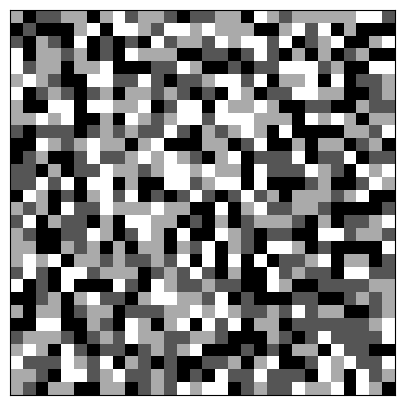

In [43]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(all_grids.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)

In [44]:
anim